<a href="https://colab.research.google.com/github/vlad98rus/-netology_pyda/blob/HomeWork-1/DZ_ocenka_to4nosti__modeli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание по теме "Оценка точности модели, переобучение, регуляризация"

Дана статистика пользователей adult.csv.

Получите значения AUC для различных моделей и их параметров.

Решением будет ссылка на гитхаб с ноутбуком.

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

In [111]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [113]:
df['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

Заменим в целевом атрибуте '>50K' на 1 и '<=50K' на 0

In [0]:
df.replace('>50K', 1, inplace=True)
df.replace('<=50K', 0, inplace=True)

Разделим выборку на тренировочную и валидационную.

In [0]:
X = df.loc[:, df.columns != 'income']
y = df[df.columns[-1]]

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

Разделим признаки на числовые и категориальные

In [0]:
num_columns = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

Получим список значений для всех категорий, для OneHotEncoder-а

In [0]:
def get_cat_categories(df, cat_columns):
    categories = []
    for column in cat_columns:
        categories.append(list(df[column].unique()))    
    return categories

In [0]:
categories = get_cat_categories(df, cat_columns)

Категориальные признаки обрабатываем OneHotEncoder-ом, численные пропускаем через StandardScaler

In [0]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories=categories), cat_columns),
        ('num', StandardScaler(), num_columns)
    ],
    sparse_threshold=0,
    remainder='drop'
)

Соберем несколько моделей с разными параметрами и вычислим predict_proba для тестовой выборки

In [0]:
results = {}

In [0]:
penalty = 'l1'
for c in np.logspace(-3, 3, 7):
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(penalty=penalty, C=c, solver='liblinear'))])
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_val)[:, 1]
    results[(penalty, c)] = y_prob

In [0]:
penalty = 'l2'
for c in np.logspace(-3, 3, 7):
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(penalty=penalty, C=c, solver='liblinear'))])
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_val)[:, 1]
    results[(penalty, c)] = y_prob

Построим ROC AUC

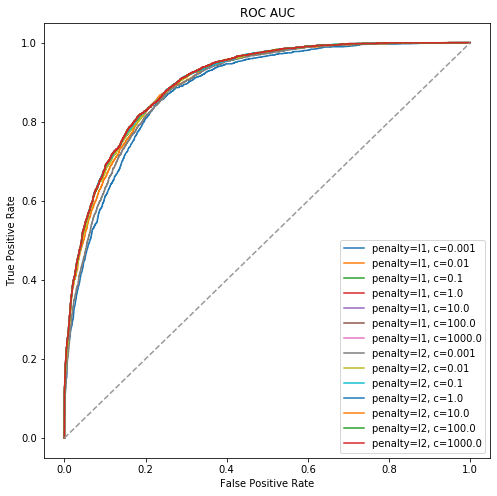

In [124]:
plt.figure(figsize=(8, 8))
for (penalty, c), proba in results.items():
    fpr, tpr, _ = roc_curve(y_val, proba)
    plt.plot(fpr, tpr, label=f'penalty={penalty}, c={c}')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc='lower right')
plt.show()

Построим PR-curve

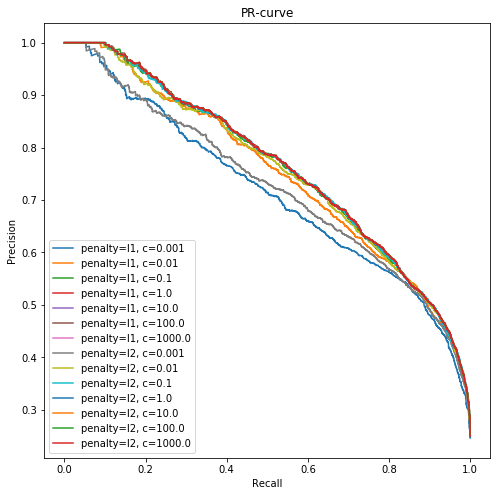

In [125]:
plt.figure(figsize=(8, 8))
for (penalty, c), proba in results.items():
    precision, recall, _ = precision_recall_curve(y_val, proba)
    plt.plot(recall, precision, label=f'penalty={penalty}, c={c}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-curve')
plt.legend(loc='lower left')
plt.show()